#### CASA0002_UrbanSimulation

In [2]:
# libraries
from operator import itemgetter
from IPython.display import display_html
from math import sqrt

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import folium
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Part 1: London’s Underground Resilience

# I. Topological Network

## I.1.1 Centrality Measures

### Betweeness Centrality
- Betweeness Centrality measures the extent to which a node lies on the shortest path between other nodes in the network.
- Contextual Defintion: It identifies stations through which the highest number of shortest paths pass through. BC identifies the stations needed to transfer passengers *efficiently* throughout the network
- Why it's important: Identifies stations that , if closed, would cause the greatest increase in journey times across the network
\begin{equation} C_{B}(v) = \sum_{s,t \neq v} \frac{\sigma_{st}(v)}{\sigma_{st}} \end{equation}

### Degree Centrality
- Definition: Degree Centrality measures the number of *one-edge* direct connections a node has.
- Contextual Defintion: This highlights the stations with the most direct connections to other stations, indicating hubs or key transfer points.
- Why it's important: Identifies the most interconnected stations. These nodes facilitate multiple route options.

\begin{equation} C_{D}(v) = \frac{deg(v)}{n-1} \end{equation}

### Closeness Centrality
- Closeness Centrality is a score that indicates how close a node is to all other nodes in the network, based on the shortest paths.
- Contextual Defintion: Point to stations that are most efficiently located to reach all other stations in the network, minimising travel time for commuters
- Why it's important: Identifies stations that offer the shortest average journey time to all other stations.

\begin{equation} C_{i}= \frac{1}{l_{i}} = \frac{n}{\sum_{j} d_{ij}}\end{equation}

## I.1.2 Construct Network

In [3]:
# read in london.graph.xml
G = nx.read_graphml("data/london_updated.graph")

# print node / edge count
print(G)

# get 'node' attributes
list(G.nodes(data=True))[0]

Graph with 401 nodes and 467 edges


('Uxbridge',
 {'coords': '(505605.79164161877, 184156.71191985375)',
  'topological_closeness': 0.049170251997541485,
  'topological_degree': 0.0025,
  'topological_betweeness': 0.0,
  'betweenness_f': 0.0})

In [4]:
# convert coords: list to tuple
for n in G.nodes():
    G.nodes[n]["coords"] = eval(G.nodes[n]["coords"])

# check
list(G.nodes(data=True))[0]

('Uxbridge',
 {'coords': (505605.79164161877, 184156.71191985375),
  'topological_closeness': 0.049170251997541485,
  'topological_degree': 0.0025,
  'topological_betweeness': 0.0,
  'betweenness_f': 0.0})

In [5]:
# get edge attributes
list(G.edges(data=True))[0]

('Uxbridge',
 'Hillingdon',
 {'length': 2144.402930417613, 'line_name': 'Piccadilly', 'flows': 7080})

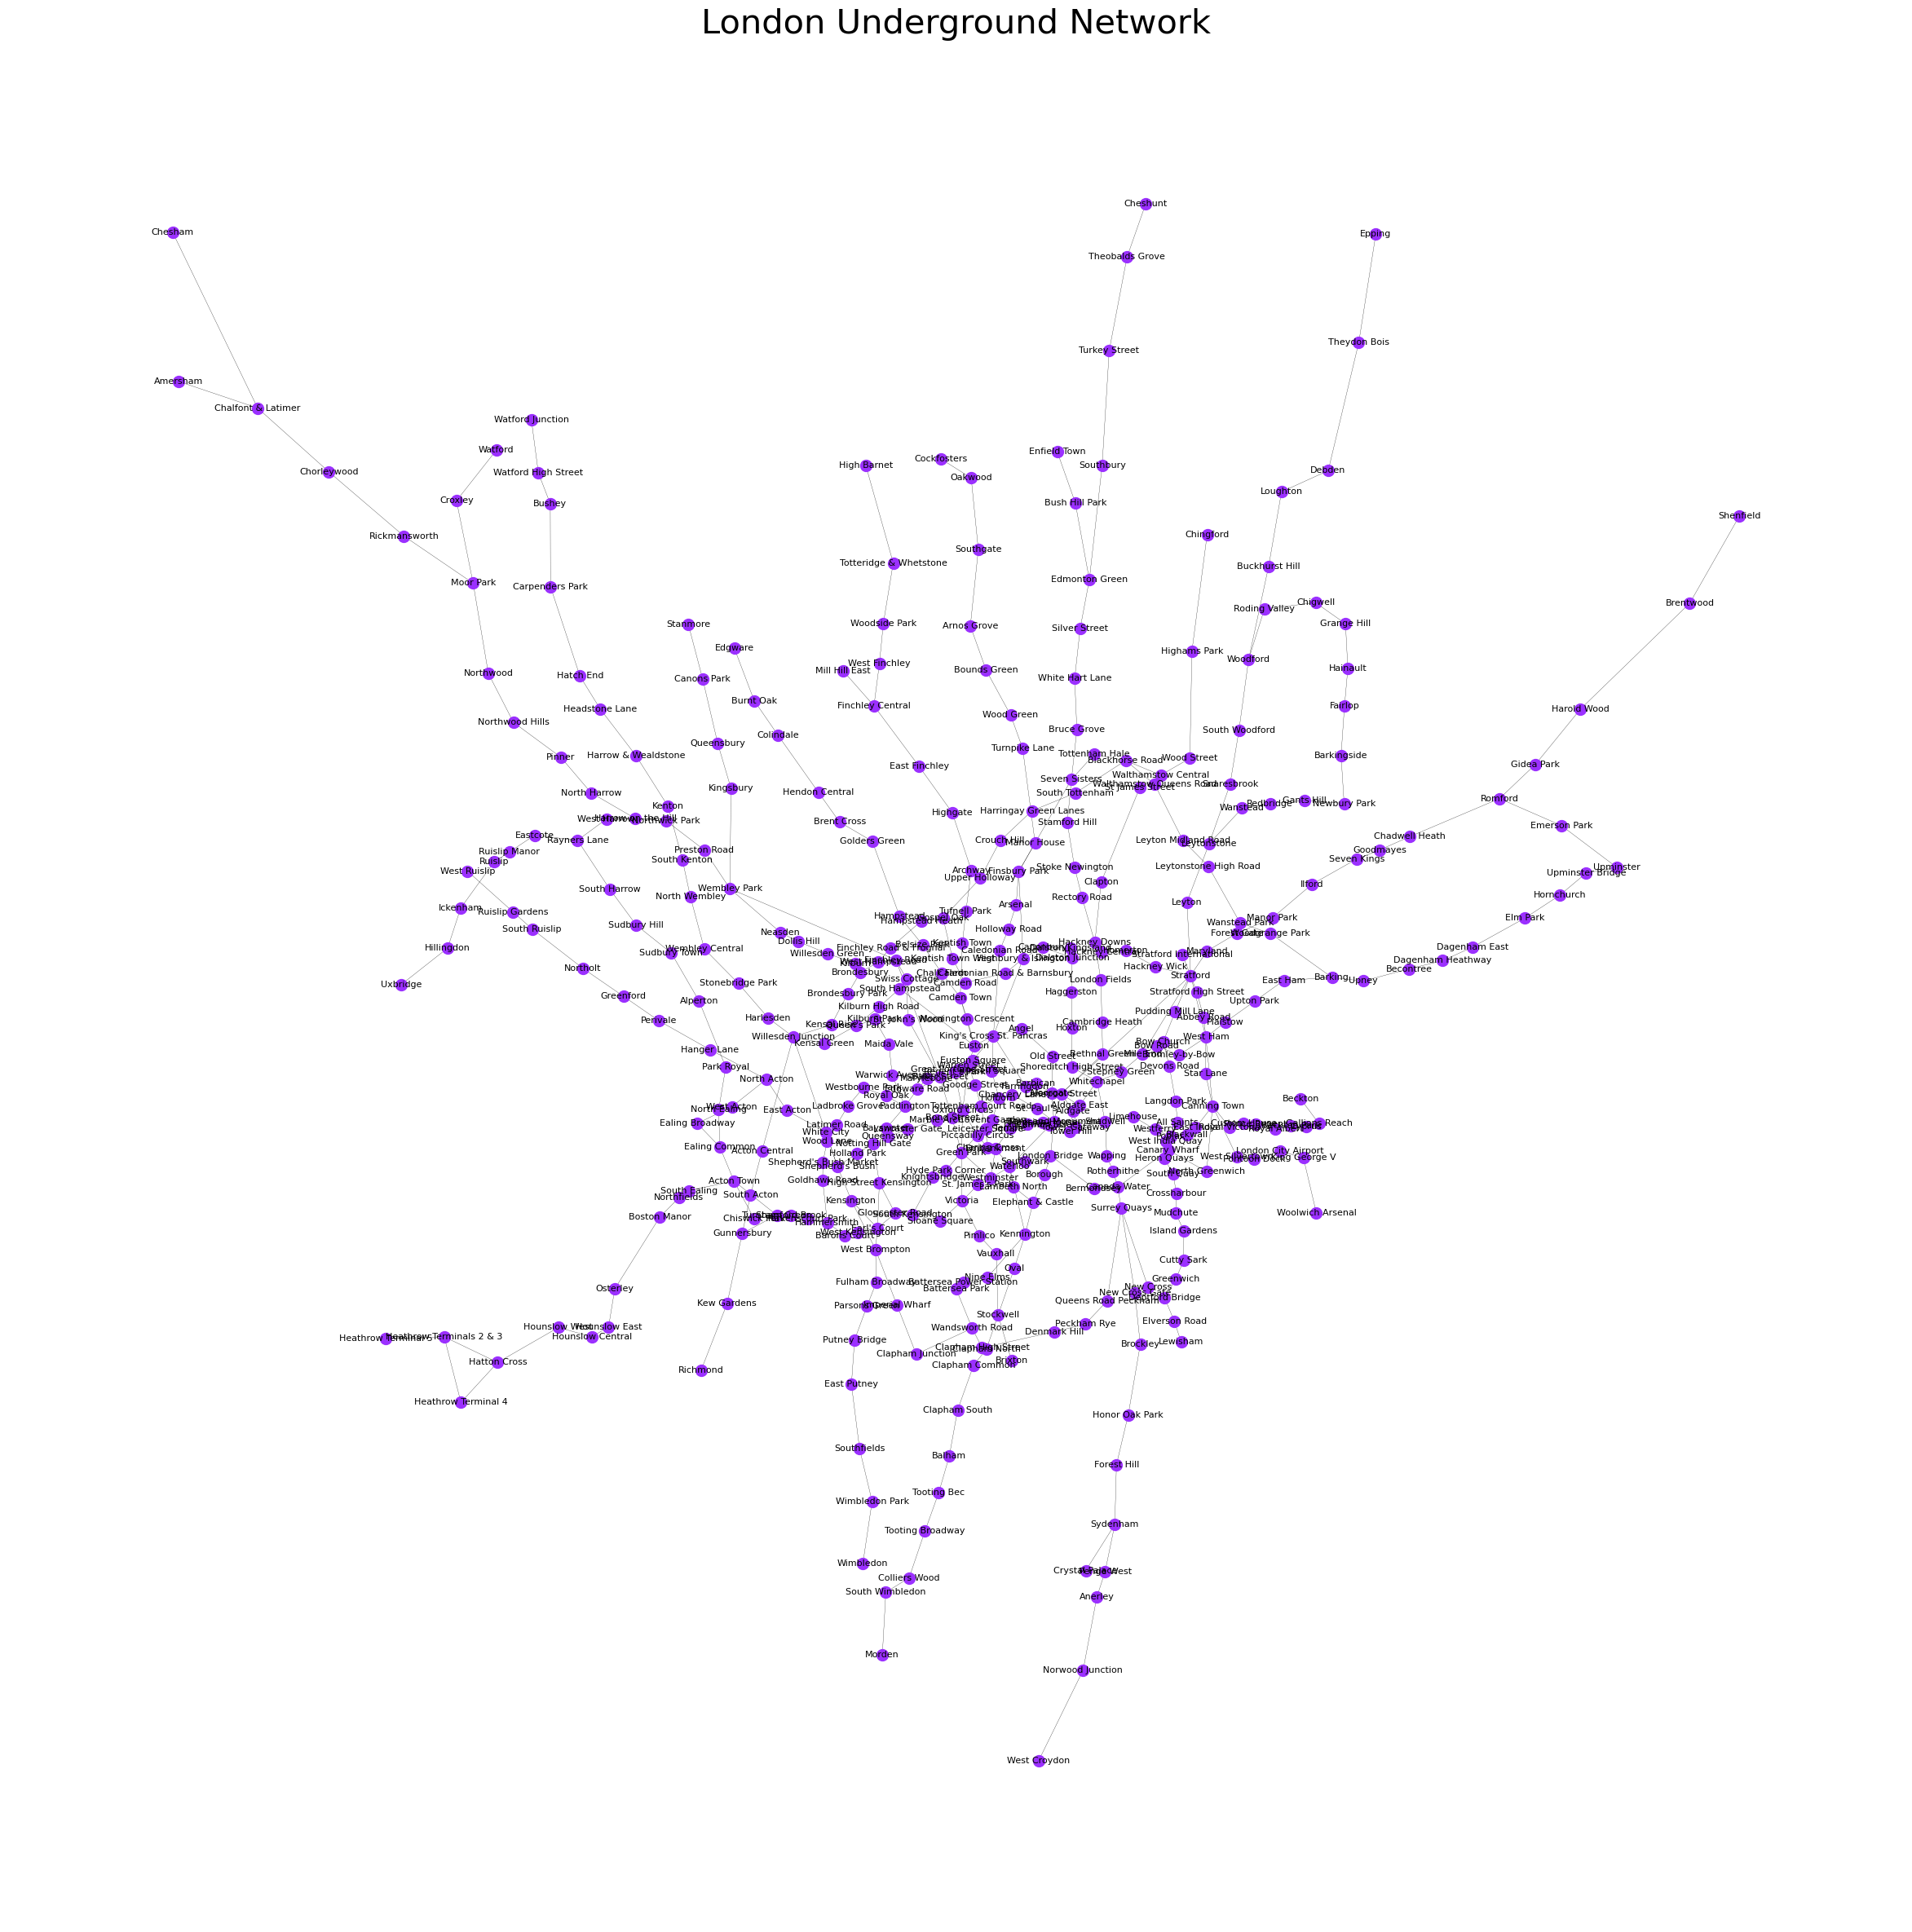

In [6]:
# edges look good
# plot tube graph
fig, ax = plt.subplots(figsize=(30, 30))
pos = nx.get_node_attributes(G, "coords")
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="#9B30FF")
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)

# station names
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

# aesthetics
plt.title("London Underground Network", fontsize=30)
plt.axis("off")
plt.show()

In [7]:
# get edge list
df = nx.to_pandas_edgelist(G)
# did it work?
df.head()

,source,target,length,flows,line_name
0,Uxbridge,Hillingdon,2144.402930,7080,Piccadilly
1,Hillingdon,Ickenham,1124.430585,8453,Piccadilly
2,Ickenham,Ruislip,1785.657867,8984,Piccadilly
3,Ruislip,Ruislip Manor,678.881293,9700,Piccadilly
4,Ruislip Manor,Eastcote,1126.217722,10497,Piccadilly


## I.1.3 Centrality Calculations

### A. Topological Closeness Centrality

In [8]:
# calculate top. closeness
top_clos = nx.closeness_centrality(G)

# add 'top. closeness' attribute to G
nx.set_node_attributes(G, top_clos, "topological_closeness")

# check
list(G.nodes(data=True))[0:5]

[('Uxbridge',
  {'coords': (505605.79164161877, 184156.71191985375),
   'topological_closeness': 0.049170251997541485,
   'topological_degree': 0.0025,
   'topological_betweeness': 0.0,
   'betweenness_f': 0.0}),
 ('Hillingdon',
  {'coords': (507544.8588852762, 185008.64550515497),
   'topological_closeness': 0.05170630816959669,
   'topological_degree': 0.005,
   'topological_betweeness': 399.0,
   'betweenness_f': 0.005}),
 ('Ickenham',
  {'coords': (508089.8084796285, 185937.75443791348),
   'topological_closeness': 0.054503338329472684,
   'topological_degree': 0.005,
   'topological_betweeness': 796.0,
   'betweenness_f': 0.009974937343358397}),
 ('Ruislip',
  {'coords': (509483.21437480004, 187013.5122156188),
   'topological_closeness': 0.0576036866359447,
   'topological_degree': 0.005,
   'topological_betweeness': 1191.0,
   'betweenness_f': 0.014924812030075188}),
 ('Ruislip Manor',
  {'coords': (510118.8736871729, 187242.51348855108),
   'topological_closeness': 0.0610593802

In [9]:
# convert to df
df_closeness_t = pd.DataFrame(index=G.nodes())
df_closeness_t["Topological_Closeness_Centrality"] = pd.Series(
    nx.get_node_attributes(G, "topological_closeness")
)

# print top 10
df_sorted = df_closeness_t.sort_values(
    ["Topological_Closeness_Centrality"], ascending=False
)
df_sorted[0:10]

,Topological_Closeness_Centrality
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


In [11]:
#plot top. clonesness
top_clos_val = [(i[1]["topological_closeness"]) for i in G.nodes(data=True)]

# set node color & width
top_clos_color = [(i[1]["topological_closeness"]) for i in G.nodes(data=True)]
top_clos_size = [
    ((i[1]["topological_closeness"] - min(clos_t_val)) / (max(clos_t_val) - min(clos_t_val)) * 50)
    for i in G.nodes(data=True)
]

# plot
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, edge_color="black", width=0.5)
nod = nx.draw_networkx_nodes(
    G, pos=pos, node_color=top_clos_color, node_size=top_clos_size
)

# aethetics, title & labels
plt.colorbar(nod, label="Closeness Centrality", orientation="horizontal", shrink=1.0)
plt.axis("off")
plt.title("Topological Closeness Centrality for London Underground", fontsize=15)
plt.show()

NameError: name 'clos_t_val' is not defined

### B. Topological Degree Centrality

In [ ]:
# calculate top. degree
top_deg = nx.degree_centrality(G)

# add 'degree' attribute to G
nx.set_node_attributes(G, dict(top_deg), "topological_degree")

# check
list(G.nodes(data=True))[0:5]

In [ ]:
# convert to df
df_degree = pd.DataFrame(index=G.nodes())
df_degree["Degree_Centrality"] = pd.Series(nx.get_node_attributes(G, "topological_degree"))

# print top 10 
df_sorted = df_degree.sort_values(["Degree_Centrality"], ascending=False)
df_sorted[0:10]

In [ ]:
# plot top. degree centrality
degrees = dict(G.degree())

# for loop to scale values
deg_size = [v * 10 for v in degrees.values()]

centrality = nx.degree_centrality(G)

# normalise values
min_cent = min(centrality.values())
max_cent = max(centrality.values())
norm_cent = [(value - min_cent) / (max_cent - min_cent) for value in centrality.values()]

# 'inferno' :)
colors = plt.cm.inferno(norm_cent)

# plot
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.4)
nod = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, node_size=deg_size)

plt.colorbar(plt.cm.ScalarMappable(cmap="inferno"), ax=ax, orientation="horizontal", label="Degree Centrality", shrink=0.7)
plt.axis("off")
plt.title("Topological Degree Centrality for London Underground", fontsize=15)
plt.show()

### C. Topological Betweeness Centrality

In [ ]:
# calculate topological betweeness
top_bet = nx.betweenness_centrality(G, normalized=False)

# add 'topological betweenness' as 'topological_betweeness'
nx.set_node_attributes(G, dict(top_bet), "topological_betweeness")

# confirm 'topological_betweeness' is added
list(G.nodes(data=True))[0:2]

In [ ]:
# convert to df
df_top_bet = pd.DataFrame(index=G.nodes())
df_top_bet["Topological Betweeness Centrality"] = pd.Series(
    nx.get_node_attributes(G, "topological_betweeness")
)

# print top 10 
df_topological_betweeness = df_top_bet.sort_values(
    ["Topological Betweeness Centrality"], ascending=False
)
df_topological_betweeness = df_topological_betweeness[0:10]

df_topological_betweeness

## I.2 Impact Measures

#### Network Diameter

**Definition:** The Network Diameter is the greatest distance you'd have to cover to travel from one node to another, given you take the shortest route

**Impact of Node Removal:** Removing a node can increase the network's diameter if the removed node was part of several shortest paths, forcing detours that lengthen the longest of these paths. A larger diameter indicates that, on average, it takes longer to get from one point to another across the network. This means that the overall efficiency of the network has decreased.

**Application:** For the London Underground, an increase in diameter might mean longer travel times for some passengers in the worst-case scenario. The same measure can be used for any network to assess how removal of nodes (such as cities in a flight network, substations in a power grid, or routers in a data network) affects the maximum transmission or travel distance.

#### Average (Shortest) Path Length

**Definition:** Given that the agent takes the shortest path, The Average Path Length average number of steps along the shortest paths for all possible pairs of network nodes.

**Impact of Node Removal:** When a node is removed, some paths get longer while others might be unreachable if the network becomes disconnected. This generally leads to an increase in the average path length, meaning that, on average, more edges must be travlled to connect different parts of the network.

**Application:** An increased average path length means longer average travel times for passengers, this mean that the efficiency of the network has decreased

#### Largest Component (LC) Size

**Definition:** Measures the size of the largest connected subgraph in a network. It reflects the network's overall connectivity.

**Impact of Node Removal:** Removing critical nodes can fragment the network, decreasing the largest component size. This indicates reduced connectivity, showing that fewer nodes can directly reach each other.

**Application:** In the London Underground, a smaller largest component suggests major disruptions, potentially leaving parts of the network inaccessible via direct routes. This measure is crucial for assessing the resilience of various networks, including transportation and communication systems, where connectivity is key.

#### Number of Connected Components

**Definition:** This metric counts distinct sub-networks within a network, where each sub-network's nodes are interconnected but isolated from others. A single connected component signifies full network connectivity.

**Impact of Node Removal:** Removing nodes increases connected components, indicating network fragmentation into isolated segments and reduced overall connectivity.

**Application:** In the London Underground, more connected components mean disruptions and potential isolation of areas. It's critical for maintaining structural integrity and ensuring no area is cut off, important for emergency planning and service continuity.

#### Global Efficiency

**Definition:** Global efficiency measures how effectively a network facilitates information transfer among nodes. It assesses communication efficiency, with higher values indicating easier reachability between nodes.

**Impact of Node Removal:** Removing key nodes reduces global efficiency, highlighting longer or less direct communication paths and indicating a less efficient network.

**Application:** For the London Underground, high global efficiency ensures efficient citywide transportation. A decline suggests longer travel times, affecting service efficiency. It's vital for urban planning and enhancing transportation network robustness.

## I.3 Node Removal Analysis

#### Create 6 Copies of G for analysis

Before conducting removal analysis, we copy G into 6 distinct graphs. This ensures that each removal process does not impact the other.

Non-sequential Analysis Graph names:
- Degree Centrality = GD_ns
- Betweenness Centrality = GB_ns
- Closeness Centrality = GC_ns

Sequential Analysis Graph names
- Degree Centrality = GD_s
- Betweenness Centrality = GB_s
- Closeness Centrality = GC_s

In [ ]:
# non-sequential graphs
GD_ns = G.copy()
GB_ns = G.copy()
GC_ns = G.copy()

# non-sequential graph list
G_ns_list = [GD_ns, GB_ns, GC_ns]

# sequential graphs
GD_s = G.copy()
GB_s = G.copy()
GC_s = G.copy()

# sequential graph list
G_s_list = [GD_s, GB_s, GC_s]

#### Move into preliminary analysis

Below, I determine a way to calculate 'Largest Component Size' & 'Average Shortest Path Length' and some other statistics

In [ ]:
# lc size & no. of connected components
# calculate no. of components, diameter of network and the no. of connected components
components = nx.connected_components(G)

# no. of connected components
num_components = nx.number_connected_components(G)

# diameter
diameter = nx.diameter(G)

# find size of lc
largest_component = max(components, key=len)


# print
print (f"The number of nodes in the largest component is {(len(largest_component))}")
print (f"The number of connected components is {num_components}")
print (f"The diameter of the London underground is {diameter}")

In [ ]:
# calc average shortest distance
components = nx.connected_components(G)
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)

# find & print the average shortest path length for lc
avg_shortest_path = nx.average_shortest_path_length(subgraph)
print (f"The average shortest path is {avg_shortest_path}")

In [ ]:
# reminder of attribute names
list(G.nodes(data=True))[0]

### I.1.3.A Non-sequential Nodel Removal

#### Non-sequential Removal: *Betweeness Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

# for loop which selects top figure from each of prev calcluated degrees

for j in range(0, 10):
    betweeness_values = [(i[1]["topological_betweeness"]) for i in GB_ns.nodes(data=True)]
    maxbet = [
        n for n in GB_ns.nodes() if GB_ns.nodes[n]["topological_betweeness"] == max(betweeness_values)
    ]
    print(f"Station removed: {maxbet}")
    # append to 'stations_removed'
    station_removed.append(maxbet[0])

    # remove the top station
    GB_ns.remove_nodes_from([maxbet[0]])
    # print new node count
    print(len(list(GB_ns.nodes)))

    # calculate & print component no.
    components_no = nx.number_connected_components(GB_ns)
    components_no_list.append(components_no)
    print(f"Number of components {components_no}")

    # list of all the components generated
    components = nx.connected_components(GB_ns)
    # find largest component
    largest_component = max(components, key=len)
    # find "subgraph" of largest component
    largest_subgraph = GB_ns.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()

    largest_comp_size_list.append(number_of_nodes)

    # print largest component average shortest path
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Largest component average shortest path is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"Global Efficiency: {global_efficiency}")

In [ ]:
# summary
df_nsbetweeness = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (non seq)",
        "No.of Components (non seq)",
        "Avg. Shortest Path (non seq)",
        "Global efficiency (non seq)",
        "Size of largest component (non seq)",
    ],
)

df_nsbetweeness

#### Non-sequential Removal: *Degree Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

for j in range(0, 10):
    degree_values = [(i[1]["topological_degree"]) for i in GD_ns.nodes(data=True)]
    maxdeg = [
        n for n in GD_ns.nodes() if GD_ns.nodes[n]["topological_degree"] == max(degree_values)
    ]
    print(maxdeg)
    # append to 'stations_removed'
    station_removed.append(maxdeg[0])

    # remove the top station
    GD_ns.remove_nodes_from([maxdeg[0]])
    # print new node count
    print(len(list(GD_ns.nodes)))

    # calculate & print component no.
    components_no = nx.number_connected_components(GD_ns)
    components_no_list.append(components_no)
    print(f"Number of components {components_no}")

    # list of all the components generated
    components = nx.connected_components(GD_ns)
    # find largest component
    largest_component = max(components, key=len)
    # find "subgraph" of largest component
    largest_subgraph = GD_ns.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()

    largest_comp_size_list.append(number_of_nodes)

    # print largest component average shortest path
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Largest component average shortest path is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"Global Efficiency: {global_efficiency}")

In [ ]:
# summary
df_nsdegree = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (non seq)",
        "No.of Components (non seq)",
        "Avg. Shortest Path (non seq)",
        "Global efficiency (non seq)",
        "Size of largest component (non seq)",
    ],
)
df_nsdegree

#### Non-sequential Removal: *Closeness Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

for j in range(0, 10):
    closeness_values = [(i[1]["topological_closeness"]) for i in GC_ns.nodes(data=True)]
    maxclos = [
        n for n in GC_ns.nodes() if GC_ns.nodes[n]["topological_closeness"] == max(closeness_values)
    ]
    print(maxclos)
    # append to 'stations_removed'
    station_removed.append(maxclos[0])

    # remove the top station
    GC_ns.remove_nodes_from([maxclos[0]])
    # print new node count
    print(len(list(GC_ns.nodes)))

    # calculate & print component no.
    components_no = nx.number_connected_components(GC_ns)
    components_no_list.append(components_no)
    print(f"Number of components {components_no}")

    # list of all the components generated
    components = nx.connected_components(GC_ns)
    # find largest component
    largest_component = max(components, key=len)
    # find "subgraph" of largest component
    largest_subgraph = GC_ns.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()

    largest_comp_size_list.append(number_of_nodes)

    # print largest component average shortest path
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Largest component average shortest path is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"Global Efficiency: {global_efficiency}")

In [ ]:
# summarise results into a df which displays: no. of components, avg shortest path, global efficiency, largest component size
df_nscloseness = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (non seq)",
        "No.of Components (non seq)",
        "Avg. Shortest Path (non seq)",
        "Global efficiency (non seq)",
        "Size of largest component (non seq)",
    ],
)
df_nscloseness

### I.1.3.B Sequential Node Removal

#### Sequential Removal: *Degree Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

for j in range(0, 10):
    # calc degree & find max node
    degree_values = [(i[1]["topological_degree"]) for i in GD_s.nodes(data=True)]
    maxdeg = [n for n in GD_s.nodes() if GD_s.nodes[n]["topological_degree"] == max(degree_values)]
    print(maxdeg)
    # append to 'station_removed'
    station_removed.append(maxdeg[0])

    # remove node:
    GD_s.remove_nodes_from([maxdeg[0]])
    # number of nodes after the removal
    print(len(list(GD_s.nodes)))

    # recalc degree centrality
    deg_cen_new = nx.degree_centrality(GD_s)
    nx.set_node_attributes(GD_s, dict(deg_cen_new), "topological_degree")

    # calc component no. & append
    components_no = nx.number_connected_components(GD_s)
    components_no_list.append(components_no)

    components = nx.connected_components(GD_s)
    print(f"Number of components {components_no}")
    # finc lc
    largest_component = max(components, key=len)
    # subgraph for lc
    largest_subgraph = GD_s.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()
    largest_comp_size_list.append(number_of_nodes)

    # lc average shortest path length
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Average shortest path in largest component is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"global_efficiency {global_efficiency}")

In [ ]:
# summarise results into a df which displays: no. of components, avg shortest path, global efficiency, largest component size
df_sdegree = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (seq)",
        "No.of Components (seq)",
        "Avg. Shortest Path (seq)",
        "Global efficiency (seq)",
        "Size of largest component (seq)",
    ],
)
# reset index to 1
df_sdegree.index = np.arange(1, len(df_sdegree) + 1)

# print
df_sdegree

#### Sequential Removal: *Betweeness Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

for j in range(0, 10):

    # calc betweeness & find max node
    betweeness_values = [(i[1]["topological_betweeness"]) for i in GB_s.nodes(data=True)]
    maxbet = [n for n in GB_s.nodes() if GB_s.nodes[n]["topological_betweeness"] == max(betweeness_values)]
    print(maxbet)
    # append to 'station_removed'
    station_removed.append(maxbet[0])

    # remove node:
    GB_s.remove_nodes_from([maxbet[0]])
    # number of nodes after the removal
    print(len(list(GB_s.nodes)))

    # recalc betweeness centrality
    bet_cen_new = nx.betweenness_centrality(GB_s)
    nx.set_node_attributes(GB_s, dict(bet_cen_new), "topological_betweeness")

    # calc component no. & append
    components_no = nx.number_connected_components(GB_s)
    components_no_list.append(components_no)

    components = nx.connected_components(GB_s)
    print(f"Number of components {components_no}")
    # finc lc
    largest_component = max(components, key=len)
    # subgraph for lc
    largest_subgraph = GB_s.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()
    largest_comp_size_list.append(number_of_nodes)

    # lc average shortest path length
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Average shortest path in largest component is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"global_efficiency {global_efficiency}")

In [ ]:
# summarise results into a df which displays: no. of components, avg shortest path, global efficiency, largest component size
df_sbetweeness = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (seq)",
        "No.of Components (seq)",
        "Avg. Shortest Path (seq)",
        "Global efficiency (seq)",
        "Size of largest component (seq)",
    ],
)
# reset index to 1
df_sbetweeness.index = np.arange(1, len(df_sbetweeness) + 1)

# print
df_sbetweeness

#### Sequential Removal: *Closeness Centrality*

In [ ]:
shortest_path_list = []
components_no_list = []
global_efficiency_list = []
largest_comp_size_list = []
station_removed = []

for j in range(0, 10):
    # calc closeness & find max node
    closeness_values = [(i[1]["topological_closeness"]) for i in GC_s.nodes(data=True)]
    maxclos = [n for n in GC_s.nodes() if GC_s.nodes[n]["topological_closeness"] == max(closeness_values)]
    print(maxclos)
    # append to 'station_removed'
    station_removed.append(maxclos[0])

    # remove node:
    GC_s.remove_nodes_from([maxclos[0]])
    # number of nodes after the removal
    print(len(list(GC_s.nodes)))

    # recalc closeness centrality
    clos_cen_new = nx.closeness_centrality(GC_s)
    nx.set_node_attributes(GC_s, dict(clos_cen_new), "topological_closeness")

    # calc component no. & append
    components_no = nx.number_connected_components(GC_s)
    components_no_list.append(components_no)

    components = nx.connected_components(GC_s)
    print(f"Number of components {components_no}")
    # finc lc
    largest_component = max(components, key=len)
    # subgraph for lc
    largest_subgraph = GC_s.subgraph(largest_component)

    # no. of nodes in largest subgraph
    number_of_nodes = largest_subgraph.number_of_nodes()
    largest_comp_size_list.append(number_of_nodes)

    # lc average shortest path length
    shortest_path = nx.average_shortest_path_length(largest_subgraph)
    shortest_path_list.append(shortest_path)
    print(f"Average shortest path in largest component is {shortest_path}")

    global_efficiency = nx.global_efficiency(largest_subgraph)
    global_efficiency_list.append(global_efficiency)
    print(f"global_efficiency {global_efficiency}")

In [ ]:
# summarise results into a df which displays: no. of components, avg shortest path, global efficiency, largest component size
df_scloseness = pd.DataFrame(
    list(
        zip(
            station_removed,
            components_no_list,
            shortest_path_list,
            global_efficiency_list,
            largest_comp_size_list,
        )
    ),
    columns=[
        "Station Removed (seq)",
        "No.of Components (seq)",
        "Avg. Shortest Path (seq)",
        "Global efficiency (seq)",
        "Size of largest component (seq)",
    ],
)
# reset index to 1
df_scloseness.index = np.arange(1, len(df_scloseness) + 1)

# print
df_scloseness

### I.1.3.C Node Removal Analysis: Results & Analysis

#### 0. This section will compare the results of the two node removal strategies and answer the following questions based on the impact measures selected in I.1.2: Global Efficiency & Average Length of Shortest Path 
- Which centrality measure best reflects the importance of a station for the functioning of the underground?
- Which strategy is more effective at studying resilience?
- Which impact measure is better at assessing the damage after node removal?

#### 1. Report the Results of the 2 Strategies in One Plot:
Visualisation of the outcomes of both the sequential and nonsequential node removal strategies on a single plot. Plot metrics to compare how each strategy affects the network:
- Average shortest path length after each node removal
- Global efficiency of the network after each node removal

Prior to plotting, the following code develops **three** dataframes that display relevant data from the analysis conducted above.

Each dataframe illustrates how Global Efficiency and Average Path Length change when the top 10 nodes are removed sequentially or non-sequentially based on their Betweeness, Closeness or Degree centrality score.

#### 1.1 Degree Plot

In [ ]:
# merge
degree_all = pd.merge(df_sdegree, df_nsdegree, left_index=True, right_index=True)

# keep columns below:
desired_columns = [
    "Station Removed (seq)",
    "Avg. Shortest Path (seq)",
    "Global efficiency (seq)",
    "Station Removed (non seq)",
    "Avg. Shortest Path (non seq)",
    "Global efficiency (non seq)",
]

# filter & print
degree_all = degree_all[[col for col in desired_columns if col in degree_all.columns]]
degree_all

In [ ]:
# plot for sequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (seq)', color='tab:blue')
ax1.plot(degree_all.index, degree_all['Avg. Shortest Path (seq)'], color='tab:blue', label='Avg. Shortest Path (seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (seq)', color='tab:red')  
ax2.plot(degree_all.index, degree_all['Global efficiency (seq)'], color='tab:red', linestyle='--', label='Global Efficiency (seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Degree Centrality: Sequential Node Removal')
fig.tight_layout()  
plt.show()

In [ ]:
# plot for nonsequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (non seq)', color='tab:blue')
ax1.plot(degree_all.index, degree_all['Avg. Shortest Path (non seq)'], color='tab:blue', label='Avg. Shortest Path (non seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (seq)', color='tab:red')  
ax2.plot(degree_all.index, degree_all['Global efficiency (non seq)'], color='tab:red', linestyle='--', label='Global Efficiency (non seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Degree Centrality: Non-Sequential Node Removal')
fig.tight_layout()  
plt.show()

#### 1.2 Betweeness Plot

In [ ]:
# merge
betweeness_all = pd.merge(df_sbetweeness, df_nsbetweeness, left_index=True, right_index=True)

# keep columns below:
desired_columns = [
    "Station Removed (seq)",
    "Avg. Shortest Path (seq)",
    "Global efficiency (seq)",
    "Station Removed (non seq)",
    "Avg. Shortest Path (non seq)",
    "Global efficiency (non seq)",
]

# filter & print
betweeness_all = betweeness_all[[col for col in desired_columns if col in betweeness_all.columns]]
betweeness_all

In [ ]:
# plot for sequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (seq)', color='tab:blue')
ax1.plot(betweeness_all.index, betweeness_all['Avg. Shortest Path (seq)'], color='tab:blue', label='Avg. Shortest Path (seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (seq)', color='tab:red')  
ax2.plot(betweeness_all.index, betweeness_all['Global efficiency (seq)'], color='tab:red', linestyle='--', label='Global Efficiency (seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Betweeness Centrality: Sequential Node Removal')
fig.tight_layout()  
plt.show()

In [ ]:
# plot for nonsequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (non seq)', color='tab:blue')
ax1.plot(betweeness_all.index, betweeness_all['Avg. Shortest Path (non seq)'], color='tab:blue', label='Avg. Shortest Path (non seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (non seq)', color='tab:red')  
ax2.plot(betweeness_all.index, betweeness_all['Global efficiency (non seq)'], color='tab:red', linestyle='--', label='Global Efficiency (non seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Betweeness Centrality: Non Sequential Node Removal')
fig.tight_layout()  
plt.show()

#### 1.3 Closeness Plot

In [ ]:
# merge
closeness_all = pd.merge(df_scloseness, df_nscloseness, left_index=True, right_index=True)

# keep columns below:
desired_columns = [
    "Station Removed (seq)",
    "Avg. Shortest Path (seq)",
    "Global efficiency (seq)",
    "Station Removed (non seq)",
    "Avg. Shortest Path (non seq)",
    "Global efficiency (non seq)",
]

# filter & print
closeness_all = closeness_all[[col for col in desired_columns if col in closeness_all.columns]]
closeness_all

In [ ]:
# plot for sequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (seq)', color='tab:blue')
ax1.plot(closeness_all.index, closeness_all['Avg. Shortest Path (seq)'], color='tab:blue', label='Avg. Shortest Path (seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (seq)', color='tab:red')  
ax2.plot(closeness_all.index, closeness_all['Global efficiency (seq)'], color='tab:red', linestyle='--', label='Global Efficiency (seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Closeness Centrality: Sequential Node Removal')
fig.tight_layout()  
plt.show()

In [ ]:
# plot for nonsequential node removal
# create figure
fig, ax1 = plt.subplots()

# plot avg. shortest path on primary y-axis
ax1.set_xlabel('Index Number')
ax1.set_ylabel('Avg. Shortest Path (non seq)', color='tab:blue')
ax1.plot(closeness_all.index, closeness_all['Avg. Shortest Path (non seq)'], color='tab:blue', label='Avg. Shortest Path (non seq)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# global efficiency on secondary y-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Global Efficiency (non seq)', color='tab:red')  
ax2.plot(closeness_all.index, closeness_all['Global efficiency (non seq)'], color='tab:red', linestyle='--', label='Global Efficiency (non seq)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Closeness Centrality: Non Sequential Node Removal')
fig.tight_layout()  
plt.show()

#### 2. Centrality Measure & Station Importance: 
Discuss which centrality measure best reflects the importance of a station within the London Underground network.

This will entail an analysis of how the removal of nodes, based on different centrality measures, affect the network's functionality and determine which centrality measure is most indicative of a station's criticality.

#### 3. Effectiveness of Strategies at Studying Resilience: 
Evaluate whether sequential or nonsequential node removal provides more insight into the resilience of the London Underground. 
*Resilience* refers to the tube's ability to maintain its overall structure and functionality despite the removal of stations.
- Which strategy better simulates real-world scenarios, such as targeted attacks (sequential) versus random failures (nonsequential)?
- How does each strategy affect the network's connectivity / performance?

#### 4. Impact Measure & Damage Assessment: 
Which impact measure is most effective at assessing the damage to the network after node removal? 

This involves determining which metric best captures the network's degradation and can be used to quantify the impact of removing nodes (according to the different strategies).

# II. Flows: Weighted Network

## II.1 Centrality in a Weighted Network 
- Do different measures need to be used when flows are considered?
- What would you need to do to adjust this measure for a weighted network? 
- Recompute the ranking of the 10 most important nodes according to this adjusted measure.
    - Do you find the same ones as in I.1?

#### II.1.0 Structuring Analysis

In section I.1. The **Betweeness**, **Closeness** and **Degree** centrality was calculated for the Topological London Underground Network. This section recalculates these values inclusive of passenger flows.

A copy of the *london.graph.xml* is created, *G_weighted*. 

*G_weighted* is created in order to manipulate the flow data (inversion outlined below) while ensuring the *G* remains untouched.

In [ ]:
G_weighted = G.copy()

# reminder of attributes
edges = list(G_weighted.edges(data=True))[0]
nodes = list(G_weighted.nodes(data=True))[0]
edges

In [ ]:
G_weighted.remove_nodes_from(["Nine Elms", "Battersea Park", "Battersea Power Station"])
# number of nodes after the removal
print(len(list(G_weighted.nodes)))

In [ ]:
print(nx.is_connected(G_weighted))

### II.1.A Calculate Betweeness Centrality inclusive of Flows

In [ ]:
# invert weights
for u, v, d in G_weighted.edges(data=True):
    d['flows_inv'] =  1 / (d.get('flows', 0) + .001)

# calc
bet_london_w = nx.betweenness_centrality(G_weighted, weight='flows_inv', normalized=True)

# set as attribute
nx.set_node_attributes(G_weighted, bet_london_w,'betweenness_centrality')

df = pd.DataFrame(index = G_weighted.nodes())
df['betweenness_f'] = pd.Series(nx.get_node_attributes(G_weighted, 'betweenness_f'))

df_weighted_betweeness = df.sort_values(["betweenness_f"], ascending=False)

# print
df_weighted_betweeness[0:10]

In [ ]:
# lets set colour and size of nodes according to betweenness values before removal
betweenness_f_values = [(i[1]["betweenness_f"]) for i in G_weighted.nodes(data=True)]

bet_t_color = [(i[1]["betweenness_f"]) for i in G_weighted.nodes(data=True)]
pos = nx.get_node_attributes(G_weighted, "coords")
bet_t_size = [
    (i[1]["betweenness_f"] / max(betweenness_f_values)) * 100
    for i in G_weighted.nodes(data=True)
]

# plot graph
fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_edges(G_weighted, pos, edge_color="gray", width=0.4)

nod = nx.draw_networkx_nodes(G_weighted, pos=pos, node_color=bet_t_color, node_size=bet_t_size)

plt.colorbar(nod, label="Inverse Weighted Betweenness Centrality", orientation="horizontal", shrink=0.7)
plt.axis("off")
plt.title("London Tube Inverse Weighted Betweenness", fontsize=15)
plt.show()

### II.1.B Calculate Betweeness Centrality inclusive of Flows & Edge Length

In [ ]:
# calc betweenness centrality using the 'length' attribute as weight
bet_london_length_w = nx.betweenness_centrality(G_weighted, weight='length', normalized=True)

# new centrality as a node attribute
nx.set_node_attributes(G_weighted, bet_london_length_w, 'betweenness_centrality_length')

# create df
df_length = pd.DataFrame(index=G_weighted.nodes())
df_length['betweenness_centrality_length'] = pd.Series(nx.get_node_attributes(G_weighted, 'betweenness_centrality_length'))

# sort
df_weighted_betweenness_length = df_length.sort_values(by='betweenness_centrality_length', ascending=False)

# print
top_10_length_based = df_weighted_betweenness_length.head(10)
top_10_length_based

In [ ]:
len(G_weighted)

In [ ]:
list(G_weighted.nodes(data=True))[0]

A higher flow indicates a stronger connection between two stations. A higher distance however alludes to a higher friction coefficient.

**Impact Metrics**

The impact metrics chosen in the previous section were *Global Efficiency* and *Average Shortest Path Length*. 

If we want to analyse distance and flow simultaneously, we must inverse one of these values. I have chosen to inverse flow. This means that, after the following inversion, going forward, a lower flow value means for a higher relationship between stations.

**Overview of the inversion process:**

The following code inverts the weights (flows) of edges in a graph to reflect the strength of connections (where higher original flows imply stronger connections) by creating a dictionary '*inv_flows*' with edge node pairs as keys and the rounded inverse of their "flows" attribute as values, using placeholders **e1** and **e2** for the start and end nodes of each edge.

### II.1.2 Betweeness Centrality: Weighted Network

The stations with the highest Betweeness Centrality in the *Weighted* Network differ significantly from the stations with the highest Betweeness Centrality in a *Topological* Network. While the order of the stations differs significantly in the two betweeness measures there are many common stations. This means that stations which rank highly in terms of Topological Betweeness will likley rank highly in terms of their Inverse Weighted Betweenness value.

This is visualised in the dataframe below.

In [ ]:
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;padding-right:20px;"'), raw=True)

# first 10 rows side x side
display_side_by_side(df_weighted_betweeness.head(10), df_topological_betweeness.head(10), df_weighted_betweenness_length.head(10))

The variation in the top ten stations across different betweenness centrality measures highlights the impact of network context and specific factors on the perceived importance of stations within the London Underground system. 

The "betweenness_f" measure, which incorporates passenger flows, elevates stations like Green Park and Bank and Monument to the top positions, highlighting their roles in facilitating passenger movements across the network. This suggests that a significant portion of the shortest paths, when considering volume of flow, go through these stations. 

On the other hand, "Topological Betweenness Centrality" focuses on the network's topology without considering passenger flows or edge lengths. This brings stations like Stratford and Bank and Monument to prominence, indicating their strategic positions in the network's structure, irrespective of the volume of passenger traffic they handle. The stark difference between these two rankings highlights how the incorporation of passenger flows shifts the emphasis towards stations that handle high volumes of traffic, even if they may not be as centrally located within the network's topology.

Incorporating edge lengths through the "betweenness_length_flow" measure further refines the centrality analysis by accounting for the actual distances or travel times between stations, alongside passenger flows. This results in Bank and Monument retaining a high rank, but also elevates stations like King's Cross St. Pancras and Oxford Circus, suggesting their significant roles when both the physical distance and the volume of passenger flows are considered. This measure likely reflects the practical realities of passenger experiences and operational concerns more closely, as it accounts for both how many people are traveling and the distances they are covering. 

The inclusion of flows and edge lengths into betweenness calculations better reflects their operational importance and the efficiency of passenger dispersal across the network. This highlights the relationship between network topology, passenger flow dynamics and physical distances in determining the centrality in a network.

## II.2 Impact Measures in a Weighted Network 

In a weighted network like the London Tube Network, where weights represent passenger flows, adjusting the measure for resilience assessment is crucial to accurately reflect the impact of closing stations. For a weighted network, traditional metrics like global efficiency and average shortest path length should consider the weights to better capture the real-world implications. Specifically, the global efficiency calculation can be adjusted to incorporate weights by considering the inverse of the passenger flows as distances, making paths with higher passenger flows more significant. 

Similarly, the average length of shortest path should be calculated using weighted distances, emphasising paths that carry more passengers. 

A more nuanced measure that could better assess the impact of closing a station is "weighted betweenness centrality," which accounts for the number of shortest paths passing through a node, weighted by passenger flows. This measure highlights stations critical for maintaining efficient passenger movement across the network, thus providing a more accurate representation of a station's importance and the impact of its closure on the network's resilience.

## II.3 Node Removal for a Weighted Network 

The top 3 stations, ranked by their weighted betweeness are *Bank and Monument*, *Kings Cross St. Pancras* and *Stratford*. This section of the analysis will be done in the 3 following sections: 

- Remove and Measure Impact for top 3 stations:
    - Remove these stations (and connecting edges) from the network.
    - Calculate the "global efficiency" and "average length of shortest path" for the network without these stations.
    - Record these metrics to assess the impact of the removal.
- Repeat with Adjusted Measure: If the adjusted measure hasn't been applied yet, calculate the new centrality rankings with this consideration, and repeat the removal and impact assessment process.
- Critical Discussion: Compare the effects of removing the top 3 stations as identified by the original and adjusted centrality measures. Discuss which removals impact the network more significantly in terms of efficiency and passenger flow, and theorize why that might be the case.

In [ ]:
print(nx.is_connected(G_weighted))

In [ ]:
list(G_weighted.nodes(data=True))[0]

#### Sequential Removal of Betweeness Centrality for a Weighted Network

In [ ]:
# empty lists
sh_path_list = []
station_removed = []
global_eff_w_list = []
components_list = []
largest_component_size_list = []

for j in range(10):
    # extract betweenness centrality value, pick max
    bet_values = nx.get_node_attributes(G_weighted, "betweenness_f")
    max_node = max(bet_values, key=bet_values.get)
    print([max_node])
    # append to 'stations removed'
    station_removed.append(max_node)

    # remove node
    G_weighted.remove_node(max_node)

    # recalc betweenness centrality
    bet_cen_new = nx.betweenness_centrality(G_weighted, normalized=True)
    nx.set_node_attributes(G_weighted, bet_cen_new, "betweenness_f")

    # calc no. of connected components & largest component size
    components = list(nx.connected_components(G_weighted))
    largest_component = max(components, key=len)
    components_list.append(len(components))
    largest_component_size_list.append(len(largest_component))
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {len(largest_component)}")

    # create subgraph of lc & calculate average shortest path length
    if len(largest_component) > 1:
        largest_subgraph = G_weighted.subgraph(largest_component)
      
        sh_path = nx.average_shortest_path_length(largest_subgraph)
        sh_path_list.append(sh_path)
        print(f"Average shortest path in largest component is {sh_path}")

        # calc global efficiency of the largest component
        global_eff_w = nx.global_efficiency(largest_subgraph)
        global_eff_w_list.append(global_eff_w)
        print(f"Weighted global_efficiency {global_eff_w}")
    else:
        sh_path_list.append(float('inf'))  # for a single node, the path length is infinite
        global_eff_w_list.append(0)  # global efficiency is 0 for a single node
        print("Largest component is a single node, skipping shortest path and global efficiency calculations.")

print("Stations Removed:", station_removed)
print("Shortest Path List:", sh_path_list)
print("Global Efficiency List:", global_eff_w_list)
print("Number of Connected Components List:", components_list)
print("Largest Component Size List:", largest_component_size_list)

#### Sequential Removal of Betweeness Centrality for a Weighted Network inclusive of Flows

In [ ]:
# empty lists
sh_path_list = []
station_removed = []
global_eff_w_list = []
components_list = []
largest_component_size_list = []

for j in range(10):
    # extract betweenness centrality value, pick max
    bet_values = [(i[1]["betweenness_centrality_length"]) for i in G_weighted.nodes(data=True)]
    maxdeg = [
        n for n in G_weighted.nodes() if G_weighted.nodes[n]["betweenness_centrality_length"] == max(bet_values)
    ]
    print(maxdeg)
    # append to 'stations removed'
    station_removed.append(maxdeg[0])

    # remove node:
    G_weighted.remove_node(maxdeg[0])

    # recalc betweenness centrality
    bet_cen_new = nx.betweenness_centrality(G_weighted)
    nx.set_node_attributes(G_weighted, bet_cen_new, "betweenness_centrality_length")

    # calc the no. onnected components & lc size
    components = list(nx.connected_components(G_weighted))
    largest_component = max(components, key=len)
    largest_component_size = len(largest_component)
    components_list.append(len(components))
    largest_component_size_list.append(largest_component_size)
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {largest_component_size}")

    # create "subgraph" of lc & calc its average shortest path length
    largest_subgraph = G_weighted.subgraph(largest_component)
    if len(largest_component) > 1:  # ensure the subgraph has more than one node
        Sh_path = nx.average_shortest_path_length(largest_subgraph, weight="inv_flows")
        Sh_path_list.append(Sh_path)
        print(f"Average shortest path in largest component is {sh_path}")

        # calc global efficiency of lc
        global_eff_w = nx.global_efficiency(largest_subgraph)
        global_eff_w_list.append(global_eff_w)
        print(f"Weighted global_efficiency {global_eff_w}")
    else:
        sh_path_list.append(float('inf'))
        global_eff_w_list.append(0)
        print("Largest component is a single node, skipping shortest path and global efficiency calculations.")

print("Stations Removed:", station_removed)
print("Shortest Path List:", sh_path_list)
print("Global Efficiency List:", global_eff_w_list)
print("Number of Connected Components List:", components_list)
print("Largest Component Size List:", largest_component_size_list)

In our analysis of the London Tube network, we observe the effects of sequentially removing stations based on their "betweenness_centrality_length" scores. 

We removed "Bank and Monument", followed by "King's Cross St. Pancras" then "Canada Water". With each station we removed, the size of the largest connected component in the network decreased slightly, indicating that while the network remains connected, it becomes slightly smaller with each removal.

Interestingly, the *average shortest path length* within the largest component stayed the same after each removal. This could suggest that the path lengths between the remaining stations in the network's main component aren't significantly affected by the removal of these high-betweenness stations. However, the global efficiency of the network decreased with each station removed. Global efficiency is a measure that tells us how well information (or passengers) can move across the network. The decrease in global efficiency after each station's removal highlights the importance of these stations. They play a crucial role in keeping the network efficient and connected. These stations, due to their positions and the volume of passenger flows, are vital for the London Tube's overall functionality.

The closure of *Bank and Monument* would have the largest impact on passengers within the London Tube network, as indicated by the decrease in global efficiency following its removal. This station's high "betweenness_centrality_length" score reflects its critical role in facilitating passenger flows across the network.

# Part 2: Spatial Interaction models

# III. Models and Calibration

### III.1 Spatial Interaction Models

- Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.

#### III.1.A Unconstrained Model

Unconstrained Model is a spatial interaction model that predicts the flow of people, goods or information between two points or nodes only based on size and distance. *Unconstrained* models are not limited by the capcity of the destination or the number of people or goods sent from the origin

*Below are the two forms the Unconstrained Spatial Interaction Model can take:*

\begin{equation} \
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

*OR*

\begin{equation} \
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

The above equations defines the flow of people or goods (*Tij*) between points *i* and *j*. Using the emissivity of the Origin, denoted as *O* and attractiveness Destination, *D*. There are several parameters ($k$, $\alpha$, $\gamma$ and $β$) used in this equation which are outlined.

- $\beta$ refers to the how sensative the person or good is to travelling marginal distance.
- $\alpha$ refers to the emissivity of the origin. This is the willingness of the population to travel from the destination.
- $\gamma$ refers to the attractiveness or *pull* of the destination.
- $k$ is the general scaling parameter. This is a measure of the size of the model and number of people interacting in the model.

#### III.1.B Singly Constrained Spatial Interaction Models

Singly constrained spatial interaction models modify the unconstrained approach by incorporating constraints on either the total outflows from origins (production-constrained) or the total inflows to destinations (attraction-constrained). These models are essential for estimating interactions between locations, such as the flow of goods, people, or information, under specific limitations.

#### III.1.B.1 Singly Origin-Constrained Model (Production-Constrained)

In a production-constrained model, the total outflows from each origin are fixed. The model is represented as:

$$
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta} \tag{1}
$$

- **$A_i$** is the origin-specific balancing factor, ensuring that the sum of predicted flows from origin $i$ matches the observed outflows.
- **$O_i$** represents the total observed outflows from origin $i$.
- The model predicts flows $T_{ij}$, adjusting them according to destination attractiveness $D_j$, distance $d_{ij}$, and the parameters $\gamma$ and $\beta$.

#### Variables and Parameters

- **$T_{ij}$**: Interaction flow from origin $i$ to destination $j$.
- **$A_i$**: Balancing factor for origin $i$.
- **$O_i$**: Total outflow from origin $i$.
- **$D_j$**: Attractiveness of destination $j$.
- **$d_{ij}$**: Distance between $i$ and $j$.
- **$\gamma$, $\beta$**: Parameters influencing the effect of $D_j$ and $d_{ij}$.

#### III.1.B.2 Singly Destination-Constrained Model (Attraction-Constrained)

Conversely, in an attraction-constrained model, the total inflows to each destination are fixed. This model can be similarly formulated but includes a balancing factor $B_j$ for each destination to ensure the sum of inflows matches observed data.

Both models serve to provide a more realistic representation of spatial interactions by accounting for the limitations in capacity or demand at either origins or destinations. They are particularly useful in transportation planning, urban development, and resource distribution analysis, offering insights into how constraints at either end of the flow affect overall spatial interaction patterns.

#### III.1.C Doubly Constrained Spatial Interaction Model

The doubly constrained spatial interaction model is described by the following equation:

$$
T_{ij} = A_i O_i B_j D_j^\gamma d_{ij}^{-\beta} \tag{1}
$$

#### Variables and Parameters

- $T_{ij}$: The flow of interactions (e.g., people, goods, information) from origin $i$ to destination $j$.
- $A_i$: The origin-specific balancing factor, adjusted to ensure that the total outflows from origin $i$ match the observed outflows.
- $O_i$: The total observed outflow of interactions from origin $i$.
- $B_j$: The destination-specific balancing factor, adjusted to ensure that the total inflows to destination $j$ match the observed inflows.
- $D_j$: The attractiveness measure or size of destination $j$.
- $d_{ij}$: The distance between origin $i$ and destination $j$, representing the cost or difficulty of moving between them.
- $\gamma$: The parameter controlling the influence of the attractiveness of destination $j$.
- $\beta$: The distance decay parameter, indicating how the interaction between $i$ and $j$ decreases with increasing distance.

#### Balancing Factors $A_i$ and $B_j$

The balancing factors are determined iteratively to ensure that the model respects both the observed total outflows from each origin and the observed total inflows to each destination:

$$
A_i = \frac{1}{\sum_j B_j D_j^\gamma d_{ij}^{-\beta}} \tag{2}
$$

$$
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}} \tag{3}
$$

#### Implementation Considerations

The doubly constrained model addresses the limitations of simpler models by ensuring that both the supply side (origins) and demand side (destinations) constraints are satisfied, reflecting more realistic scenarios where both origins and destinations have capacity or budget constraints.

The iterative calculation of $A_i$ and $B_j$ requires an initial estimation followed by successive adjustments until the model predictions adequately fit the observed data, making it a more comprehensive but computationally intensive approach compared to singly constrained models.

This model is widely used in transportation planning, migration studies, and urban planning to predict flows of people, goods, or information between spatially distributed points, accounting for both origin and destination constraints.

### III.2 Model Selection & Calibration 

#### III.2.A Explore & Process London Flows Dataset

Section III.2.A will explore and preprocess the london_flows.csv data. By transforming the dataset into a matrix, we can see the substantial number of 0s in the *flows* column. These are largely explained by 0 station-to-station flows and Battersea Park, a station that was not operational when this data was collected. This is likely due to limited service and closure during the rennovation of the Batterseas Power Station complex.

The following code identifies and removes the 0s from the csv file.

In [13]:
# flows data
london_flows = pd.read_csv("data/london_flows.csv")
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.410852
1,Abbey Road,Beckton,1,599,442,8510.047006
2,Abbey Road,Blackwall,3,599,665,3775.359872
3,Abbey Road,Canary Wharf,1,599,58772,5086.404941
4,Abbey Road,Canning Town,37,599,15428,2228.874185


In [14]:
# check csv
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [15]:
# define r^2 and RMSE calculations
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(np.sqrt(res.mean()), 3)
    
    return RMSE

In [16]:
# pivot table
london_flows_pivot = pd.pivot_table(
    london_flows,
    values="flows",
    index="station_origin",
    columns="station_destination",
    aggfunc=np.sum,
    margins=True,
)
london_flows_pivot

pd.set_option("display.max_columns", None)
london_flows_pivot

/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_46097/2699966579.py:2: FutureWarning: The provided callable <function sum at 0x107a596c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  london_flows_pivot = pd.pivot_table(
/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_46097/2699966579.py:2: FutureWarning: The provided callable <function sum at 0x107a596c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  london_flows_pivot = pd.pivot_table(
/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_46097/2699966579.py:2: FutureWarning: The provided callable <function sum at 0x107a596c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep curr

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Battersea Park,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,Sou

#### Total Flow Count: 1542391

In [17]:
london_flows = london_flows[(london_flows!=0).all(1)]

In [18]:
london_flows[london_flows["station_origin"] == "Battersea Park"]

,station_origin,station_destination,flows,population,jobs,distance


In [19]:
# remove battersea park
london_flows.drop(
    london_flows[london_flows["station_origin"] == "Battersea Park"].index, inplace=True
)

In [20]:
# check
london_flows[london_flows["station_origin"] == "Battersea Park"]

,station_origin,station_destination,flows,population,jobs,distance


In [21]:
london_flows[london_flows["station_destination"] == "Battersea Park"]

,station_origin,station_destination,flows,population,jobs,distance


In [22]:
# drop battersea park
london_flows.drop(
    london_flows[london_flows["station_destination"] == "Battersea Park"].index,
    inplace=True,
)

In [23]:
# check
london_flows[london_flows["station_destination"] == "Battersea Park"]

,station_origin,station_destination,flows,population,jobs,distance


In [24]:
london_flows[london_flows["distance"] == 0]

,station_origin,station_destination,flows,population,jobs,distance


In [25]:
london_flows.drop(london_flows[london_flows["distance"] == 0].index, inplace=True)

In [26]:
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43945 entries, 1 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       43945 non-null  object 
 1   station_destination  43945 non-null  object 
 2   flows                43945 non-null  int64  
 3   population           43945 non-null  int64  
 4   jobs                 43945 non-null  int64  
 5   distance             43945 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.3+ MB


#### III.2.B Doubly Constrained Spatial Interaction Model

For this experiment we will use a Doubly Constrained Spatial Interaction Model with Exponential Decay. 

Exponential Decay suggests that the number of passengers traveling between two points decreases rapidly with distance. This model is used to describe how the likelihood of travel between two points decreases as the distance between them increases, based on the assumption that people prefer to travel shorter distances if possible.

For passenger flows between underground stations, an exponential decay model alludes to the decrease in passenger numbers with increasing distance. This seems to underpin many spatial interaction models where distance is a key factor in determining travel behavior.

In [27]:
import numpy as np

# set x as pop jobs & dist
x_variables = ["population", "jobs", "distance"]

# apply exponential decay transformation to 'distance'
london_flows["exp_decay_distance"] = np.exp(-london_flows["distance"])

# update formula - include transformed distance variable
dbl_form = "flows ~ station_destination + station_origin + exp_decay_distance - 1"

# run  dcm regression & print summary
import statsmodels.formula.api as smf

dcm = smf.glm(
    formula=dbl_form,
    data=london_flows,
    family=sm.families.Poisson()
).fit()

print(dcm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43150
Model Family:                 Poisson   Df Model:                          794
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0797e+06
Date:                Wed, 03 Apr 2024   Deviance:                   1.9873e+06
Time:                        18:04:00   Pearson chi2:                 3.78e+06
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# IV. Scenarios